<a href="https://colab.research.google.com/github/ngthvinhrai/NeuralNetwork_Implementation/blob/main/Neural_Networks_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import asarray
import random
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import torch
torch.cuda.is_available()

True

##KAGGLE_API


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jidhumohan/mnist-png

 97% 57.0M/58.6M [00:03<00:00, 21.2MB/s]
100% 58.6M/58.6M [00:03<00:00, 15.4MB/s]


In [ ]:
!unzip "/content/mnist-png.zip" -d "/content/dataset/"

##DATA_PREPARING

In [ ]:
image = Image.open(f'/content/DATASET/{8}.png')
data = asarray(image)

ti = []
to = []
for i in range(28):
  for j in range(28):
    ti.append([i/(28-1), j/(28-1)])
    to.append([data[i][j]])

ti = np.array(ti)
to = np.array(to)/255
t = np.concatenate((ti,to), axis=1)
# plt.imshow(data, cmap='gray')

In [ ]:
ti.shape

(784, 2)

In [ ]:
to.shape

(784, 1)

In [ ]:
to[0]

array([0.])

In [ ]:
t[1:3, 2].reshape(2,-1).shape

(2, 1)

In [ ]:
def row_shuffle(input, output):
  n = len(input)
  for i in range(n-1):
    k = np.random.randint(i+1, n)
    for j in range(input.shape[1]):
      input[i][j], input[k][j] = input[k][j], input[i][j]
    for j in range(output.shape[1]):
        output[i][j], output[k][j] = output[k][j], output[i][j]

In [ ]:
tei = [[1,2,3], [4,5,6], [7,8,9]]
teo = [[1], [2], [3]]


In [ ]:
ti[0:2]

array([[0.        , 0.        ],
       [0.        , 0.03703704]])

In [ ]:
row_shuffle(ti, to)

In [ ]:
ti

array([[0.77777778, 0.22222222],
       [0.33333333, 0.11111111],
       [0.07407407, 0.66666667],
       ...,
       [0.14814815, 0.18518519],
       [0.7037037 , 0.59259259],
       [0.25925926, 1.        ]])

##IMPLEMENTATION

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [ ]:
def relu(x, rate=0):
  return np.maximum(x,x*rate)

def partial_drelu(x, rate=0):
  if x>0:
    return 1
  else:
    return rate

drelu = np.vectorize(partial_drelu)


In [ ]:
x = np.array([[1,2,3,4]])
drelu(x)

array([[1, 1, 1, 1]])

In [ ]:
def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

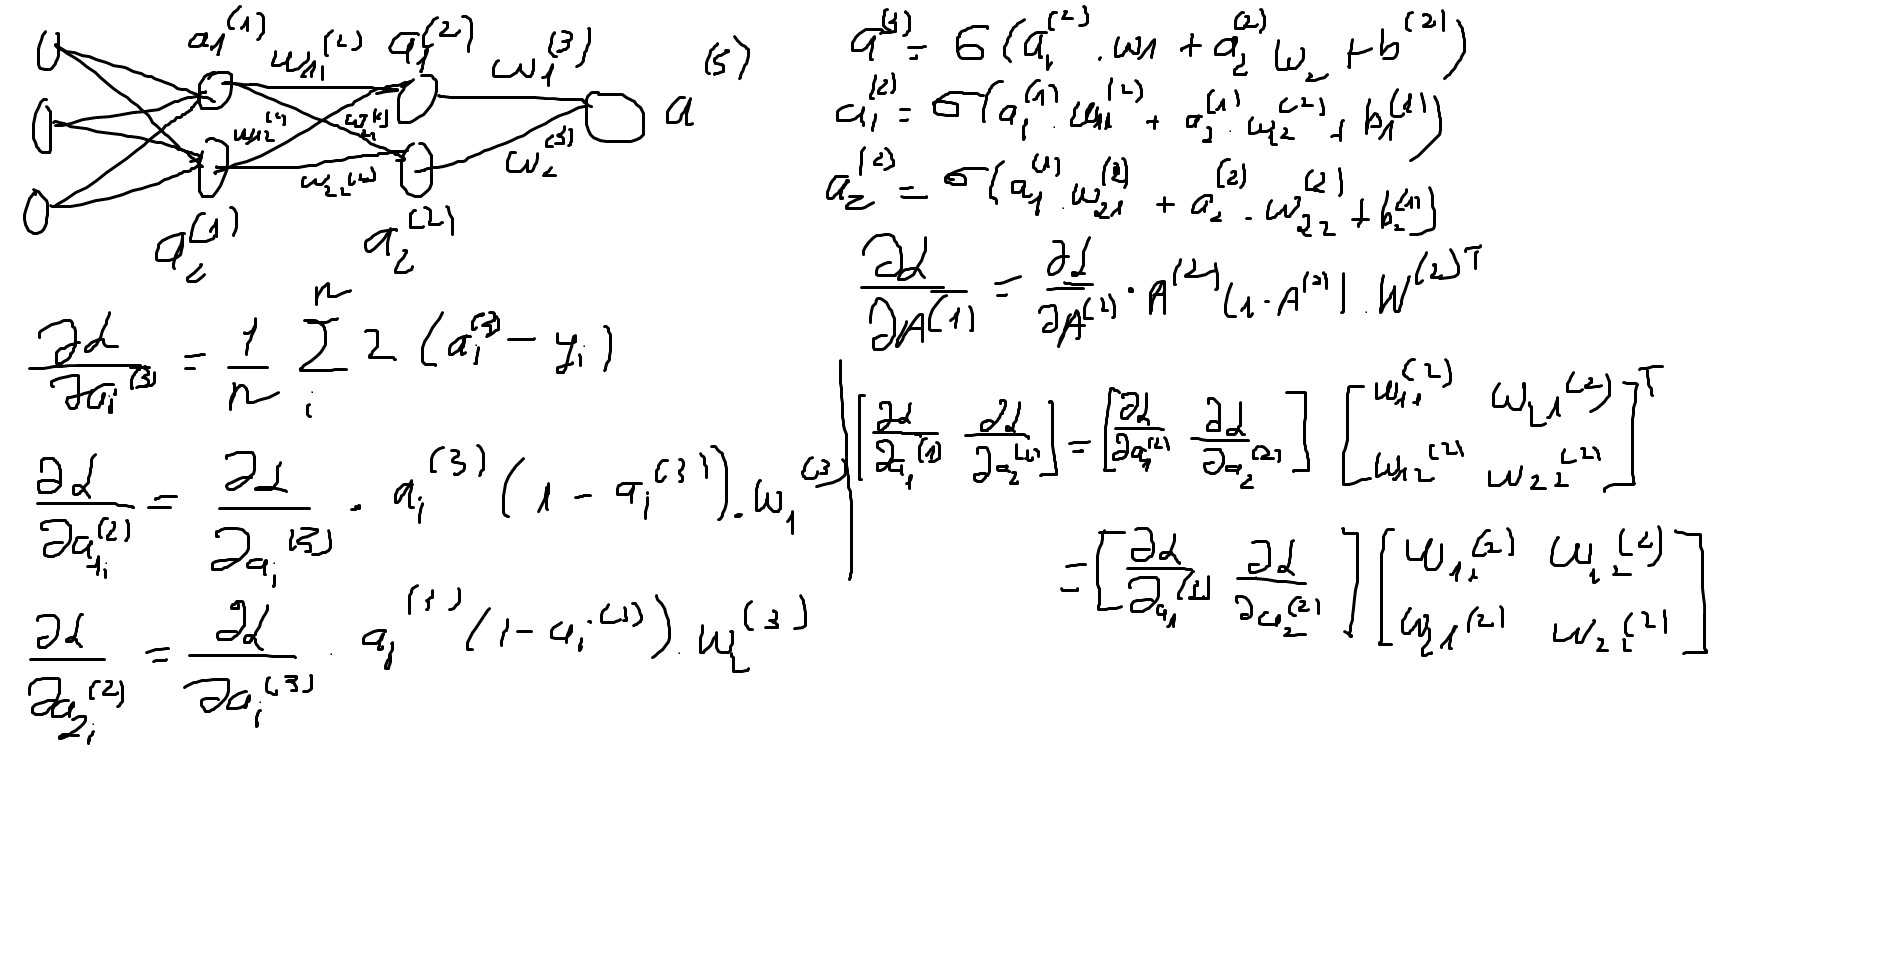

In [ ]:

class NeuralNetwork:
  def __init__(self, architecture, **kwargs):
    self.architecture = architecture
    self.num_layers = len(architecture)
    self.num_avail_layers = len(architecture) - 1
    self.activation = kwargs['activation']
    self.loss = 0
    self.A = {}
    self.W = {}
    self.B = {}

  def nn_initialize(self):
    for i in range(self.num_layers):
      self.A[i] = np.zeros((1, self.architecture[i]))

    for i in range (1, self.num_layers):
      self.W[i] = np.random.rand(self.architecture[i-1], self.architecture[i])*2-1
      self.B[i] = np.random.rand(1, self.architecture[i])*2-1

  def __row_shuffle(self, input, output):
    n = len(input)
    for i in range(n-1):
      k = np.random.randint(i+1, n)
      for j in range(input.shape[1]):
        input[i][j], input[k][j] = input[k][j], input[i][j]
      for j in range(output.shape[1]):
          output[i][j], output[k][j] = output[k][j], output[i][j]

  def forward(self, input):
    assert(self.A[0].shape[1] == input.shape[1])
    self.A[0] = np.copy(input)
    for i in range(1, self.num_layers):
      match self.activation:
        case 'relu':
          self.A[i] = relu(np.dot(self.A[i-1], self.W[i]) + self.B[i], 0.01)
        case 'tanh':
          self.A[i] = tanh(np.dot(self.A[i-1], self.W[i]) + self.B[i])
        case 'sigmoid':
          self.A[i] = sigmoid(np.dot(self.A[i-1], self.W[i]) + self.B[i])

  def cost(self, output):
    assert(self.A[self.num_avail_layers].shape[0] == output.shape[0])
    assert(self.A[self.num_avail_layers].shape[1] == output.shape[1])
    n = output.shape[0]
    return np.sum(((self.A[self.num_avail_layers] - output)**2)/n)

  def back_propagation(self, input, output):
    n = input.shape[0]
    dA = {}
    dW = {}
    dB = {}
    dA[self.num_avail_layers] = 2*(self.A[self.num_avail_layers] - output)/n
    for i in reversed(range(1, self.num_layers)):
      match self.activation:
        case 'relu':
          d_activation = drelu(np.dot(self.A[i-1], self.W[i]) + self.B[i], 0.01)
        case 'tanh':
          d_activation = 1 - self.A[i]**2
        case 'sigmoid':
          d_activation = self.A[i]*(1 - self.A[i])
      dW[i] = np.dot(self.A[i-1].T, np.multiply(dA[i], d_activation))
      dB[i] = np.sum(np.multiply(dA[i], d_activation), axis=0)
      dA[i-1] = np.dot(np.multiply(dA[i], d_activation), self.W[i].T)
    return dW, dB

  def __gd(self, input, output, learning_rate, epoch):
    for ep in range(0, epoch):
      self.forward(input)
      self.loss = self.cost(output)
      dW, dB = self.back_propagation(input, output)
      for i in range(1, self.num_layers):
        self.W[i] -= learning_rate * dW[i]
        self.B[i] -= learning_rate * dB[i]
      if ep%1000==0:
        print("loss = ", self.loss)

  def __bgd(self, input, output, learning_rate, epoch, **kwargs):
    n = input.shape[0]
    for ep in range(epoch):
      self.loss = 0
      batch_begin = 0
      if kwargs['shuffle'] == True:
        self.__row_shuffle(input, output)
      while batch_begin < n:
        ti = input[batch_begin : batch_begin + kwargs['batch_size']]
        to = output[batch_begin : batch_begin + kwargs['batch_size']]
        self.forward(ti)
        self.loss += self.cost(to)
        dW, dB = self.back_propagation(ti,to)
        for i in range(1, self.num_layers):
          self.W[i] -= learning_rate*dW[i]
          self.B[i] -= learning_rate*dB[i]
        batch_begin += kwargs['batch_size']
      if ep%1000==0:
        print(f"{ep}, LOSS: ", self.loss)

  def learn(self, input, output, learning_rate, epoch=1000, **kwargs):
    match kwargs['optimizer']:
      case 'GD':
        self.__gd(input, output, learning_rate, epoch)
      case 'BGD':
        self.__bgd(input, output, learning_rate, epoch, batch_size = kwargs['batch_size'], shuffle = kwargs['shuffle'])

  def __call__(self, x, y):
    self.nn_initialize()
    self.forward(x)
    self.cost(y)


In [ ]:
input = np.array([[0,0], [0,1], [1,0], [1,1]])
output = np.array([[1], [0], [0], [1]])

In [ ]:
rd = np.random.RandomState(1234567890)
model = NeuralNetwork([2,7,4,1], activation = 'relu')
model.nn_initialize()

In [ ]:
print("A:")
print(model.A)
print("-----------------------")
print("W: ")
print(model.W)
print("-----------------------")
print("B: ")
print(model.B)

A:
{0: array([[0., 0.]]), 1: array([[0., 0., 0., 0., 0., 0., 0.]]), 2: array([[0., 0., 0., 0.]]), 3: array([[0.]])}
-----------------------
W: 
{1: array([[-0.15860936, -0.2928739 ,  0.35364271,  0.94752836, -0.72451936,
         0.99269436,  0.26135189],
       [-0.93557239, -0.39854412, -0.28697523,  0.43163598, -0.42149554,
        -0.36749883, -0.55663928]]), 2: array([[ 0.92498909, -0.98428633,  0.19728898,  0.91064946],
       [ 0.74310646,  0.61510021,  0.43879801, -0.67221718],
       [-0.30987315,  0.11199437, -0.8294871 , -0.61055421],
       [-0.08540706, -0.25157592,  0.21441316,  0.01135417],
       [ 0.06929017,  0.56478682, -0.49440897, -0.37764121],
       [-0.95582701,  0.11525702, -0.38084682, -0.89560927],
       [-0.68327307,  0.71466917, -0.85244298,  0.15129339]]), 3: array([[-0.5723882 ],
       [-0.06423468],
       [ 0.7015033 ],
       [ 0.51752696]])}
-----------------------
B: 
{1: array([[ 0.27424287,  0.06774817,  0.96231356, -0.40224927,  0.31339458,
    

In [ ]:
model.W[1] = np.array([[-0.997497, 0.127171, -0.613392, 0.617481, 0.170019, -0.040254, -0.299417], [0.791925, 0.645680, 0.493210, -0.651784, 0.717887, 0.421003, 0.027070]])
model.W[2] = np.array([[-0.108615, -0.761834, -0.990661, -0.982177],
                       [-0.244240, 0.063326, 0.142369, 0.203528],
                       [0.214332, -0.667531, 0.326090, -0.098422],
                       [-0.295755, -0.885922, 0.215369, 0.566637],
                       [0.605213, 0.039766, -0.396100, 0.751945],
                       [0.453352, 0.911801, 0.851436, 0.078707],
                       [-0.715323, -0.075839, -0.529344, 0.724479]])
model.W[3] = np.array([[0.999390], [0.222999], [-0.215125], [-0.467574]])

In [ ]:
model.B[1] = np.array([[-0.392010, -0.970031, -0.817194, -0.271096, -0.705374, -0.668203, 0.977050]])
model.B[2] = np.array([[-0.580798, 0.559313, 0.687307, 0.993591]])
model.B[3] = np.array([[-0.405438]])

In [ ]:
model.B

{1: array([[-0.39201 , -0.970031, -0.817194, -0.271096, -0.705374, -0.668203,
          0.97705 ]]),
 2: array([[-0.580798,  0.559313,  0.687307,  0.993591]]),
 3: array([[-0.405438]])}

In [ ]:
model.forward(ti)
model.A[model.num_layers-1].shape

(784, 1)

In [ ]:
model.cost(to)
model.loss

0.606733375903155

In [ ]:
model.learn(ti, to, 1, epoch=10000, optimizer = 'GD')

loss =  1.410356991138002
loss =  0.06825476568647054
loss =  0.04817602279300293
loss =  0.04405923659886206
loss =  0.04343468828242654
loss =  0.0427228328009597
loss =  0.042313280282451904
loss =  0.041929343830012566
loss =  0.04090834017287718
loss =  0.04010769257091175


In [ ]:
ti

array([[0.        , 0.        ],
       [0.        , 0.03703704],
       [0.        , 0.07407407],
       ...,
       [1.        , 0.92592593],
       [1.        , 0.96296296],
       [1.        , 1.        ]])

In [ ]:
model.B[2]

In [ ]:
model.A[3]

In [ ]:
print("A:")
print(model.A)
print("-----------------------")
print("W: ")
print(model.W)
print("-----------------------")
print("B: ")
print(model.B)

In [ ]:
image = Image.open(f'/content/DATASET/{8}.png')
data = asarray(image)
ti = []
to = []
for i in range(28):
  for j in range(28):
    ti.append([i/(28-1), j/(28-1)])
    to.append([data[i][j]])

ti = np.array(ti)
to = np.array(to)/255

In [ ]:
model.forward(ti)

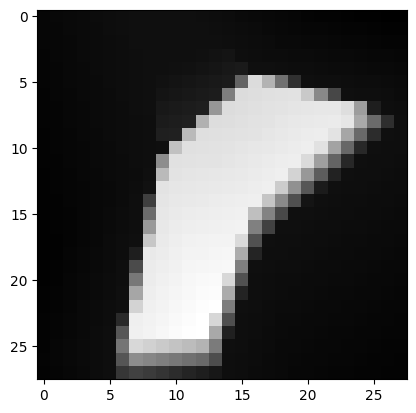

In [ ]:
output = model.A[model.num_layers-1].reshape(-1,28)
# for i in range(28):
#   for j in range(28):
#     output[i][j] = model.A[model.num_layers-1][i*28+j]

plt.imshow(output, cmap='gray')

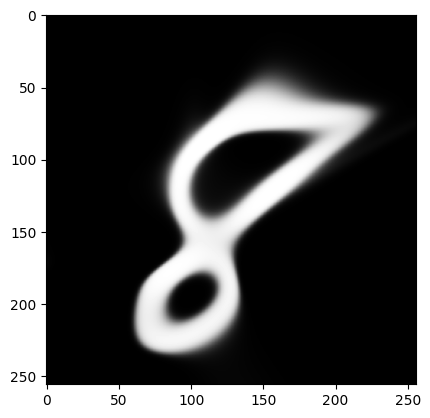

In [ ]:
up_size = 256
upscale = np.zeros((up_size,up_size))

for i in range(up_size):
  for j in range(up_size):
    model.forward(np.array([[i/(up_size-1),j/(up_size-1)]]))
    upscale[i][j] = model.A[3]

plt.imshow(upscale, cmap='gray')